In [1]:
# Cell 1: install audio libs and import everything

#!pip install librosa soundfile --quiet

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay,
    classification_report
)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import librosa
import librosa.display
import joblib

print("TensorFlow:", tf.__version__)


TensorFlow: 2.20.0


In [2]:
# Cell 2: build df_audio with filepath + status (1=PD, 0=Healthy)

audio_base = "/kaggle/input/parkisons-voice-dataset"

audio_rows = []
for root, dirs, files in os.walk(audio_base):
    for fname in files:
        if not fname.lower().endswith(".wav"):
            continue
        full_path = os.path.join(root, fname)

        if "PD_AH" in full_path:
            status = 1       # Parkinson
        elif "HC_AH" in full_path:
            status = 0       # Healthy
        else:
            continue

        audio_rows.append({"filepath": full_path, "status": status})

df_audio = pd.DataFrame(audio_rows)
print(df_audio.head())
print("\nTotal audio samples:", len(df_audio))
print("Class counts:\n", df_audio["status"].value_counts())


                                            filepath  status
0  /kaggle/input/parkisons-voice-dataset/PD_AH/PD...       1
1  /kaggle/input/parkisons-voice-dataset/PD_AH/PD...       1
2  /kaggle/input/parkisons-voice-dataset/PD_AH/PD...       1
3  /kaggle/input/parkisons-voice-dataset/PD_AH/PD...       1
4  /kaggle/input/parkisons-voice-dataset/PD_AH/PD...       1

Total audio samples: 81
Class counts:
 status
0    41
1    40
Name: count, dtype: int64


In [3]:
# Cell 3: helper - wav -> MFCC mean vector (baseline features)

def mfcc_from_file(path, sr=16000, n_mfcc=40, max_duration=3.0):
    """
    1. Load wav, resample to sr.
    2. Trim or pad to max_duration.
    3. Compute MFCCs and return mean over time: shape (n_mfcc,)
    """
    try:
        audio, _ = librosa.load(path, sr=sr)
    except Exception as e:
        print("Error loading", path, ":", e)
        return None

    max_len = int(max_duration * sr)
    if len(audio) > max_len:
        audio = audio[:max_len]
    else:
        audio = np.pad(audio, (0, max_len - len(audio)))

    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    return mfcc.mean(axis=1).astype("float32")


In [4]:
# Cell 4: build X_audio_mfcc, y_audio for baseline MLP

mfcc_features = []
labels_audio = []

for _, row in df_audio.iterrows():
    feats = mfcc_from_file(row["filepath"])
    if feats is None:
        continue
    mfcc_features.append(feats)
    labels_audio.append(row["status"])

X_audio_mfcc = np.array(mfcc_features)
y_audio = np.array(labels_audio, dtype=int)

print("MFCC feature shape:", X_audio_mfcc.shape)
print("Label distribution:", np.bincount(y_audio))


MFCC feature shape: (81, 40)
Label distribution: [41 40]


In [5]:
# Cell 5: split and scale MFCC features

X_a_train, X_a_test, y_a_train, y_a_test = train_test_split(
    X_audio_mfcc, y_audio,
    test_size=0.2,
    random_state=42,
    stratify=y_audio
)

scaler_audio_mfcc = StandardScaler()
X_a_train_s = scaler_audio_mfcc.fit_transform(X_a_train)
X_a_test_s  = scaler_audio_mfcc.transform(X_a_test)

print("MFCC train:", X_a_train_s.shape, " test:", X_a_test_s.shape)


MFCC train: (64, 40)  test: (17, 40)


In [6]:
# Cell 6: baseline audio model (MFCC -> MLP)  -- for comparison only

input_dim_mfcc = X_a_train_s.shape[1]

audio_mfcc_mlp = models.Sequential([
    layers.Input(shape=(input_dim_mfcc,)),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(32, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(1, activation="sigmoid")
])

audio_mfcc_mlp.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

mfcc_ckpt = "/kaggle/working/model_voice_audio_mfcc_best.keras"

callbacks_mfcc = [
    EarlyStopping(monitor="val_loss", patience=55, restore_best_weights=True),
    ModelCheckpoint(mfcc_ckpt, monitor="val_loss", save_best_only=True)
]

history_mfcc = audio_mfcc_mlp.fit(
    X_a_train_s, y_a_train,
    epochs=100,
    batch_size=16,
    validation_split=0.2,
    callbacks=callbacks_mfcc,
    verbose=1
)

print("Baseline MFCC training done.")


I0000 00:00:1765274231.870191      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1765274231.870780      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Epoch 1/100


I0000 00:00:1765274234.202570     129 service.cc:148] XLA service 0x7f55bc006fd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1765274234.203260     129 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1765274234.203280     129 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1765274234.460340     129 cuda_dnn.cc:529] Loaded cuDNN version 90300


1/4 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - accuracy: 0.6250 - loss: 0.6927

I0000 00:00:1765274235.837062     129 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 583ms/step - accuracy: 0.5858 - loss: 0.7178 - val_accuracy: 0.3846 - val_loss: 0.7954
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5012 - loss: 0.6758 - val_accuracy: 0.2308 - val_loss: 0.8064
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7240 - loss: 0.6349 - val_accuracy: 0.1538 - val_loss: 0.8204
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6463 - loss: 0.6232 - val_accuracy: 0.1538 - val_loss: 0.8320
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6359 - loss: 0.6389 - val_accuracy: 0.1538 - val_loss: 0.8475
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5884 - loss: 0.7167 - val_accuracy: 0.0769 - val_loss: 0.8630
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7178 - loss: 0.5727 - val_accuracy: 0.0769 - val_loss: 0.8799
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5926 - loss: 0.6422 - val_accuracy: 0.0769 - val_loss: 0.8953
Epo

In [7]:
# Cell 7: helper - wav -> Mel-spectrogram image (128x128)

def mel_spectrogram_image(
    path,
    sr=16000,
    n_fft=1024,
    hop_length=512,
    n_mels=128,
    max_duration=3.0,
    target_width=128
):
    """
    Returns Mel-spectrogram (n_mels, target_width) normalized to [0,1]
    """
    try:
        audio, _ = librosa.load(path, sr=sr)
    except Exception as e:
        print("Error loading", path, ":", e)
        return None

    max_len = int(max_duration * sr)
    if len(audio) > max_len:
        audio = audio[:max_len]
    else:
        audio = np.pad(audio, (0, max_len - len(audio)))

    mel_spec = librosa.feature.melspectrogram(
        y=audio, sr=sr, n_fft=n_fft,
        hop_length=hop_length, n_mels=n_mels
    )
    mel_db = librosa.power_to_db(mel_spec, ref=np.max)
    mel_db = librosa.util.fix_length(mel_db, size=target_width, axis=1)

    # normalize to 0–1
    min_v, max_v = mel_db.min(), mel_db.max()
    mel_norm = (mel_db - min_v) / (max_v - min_v + 1e-8)
    return mel_norm.astype("float32")


In [8]:
# Cell 8: build spectrogram tensor for CNN

spec_list = []
labels_spec = []

for _, row in df_audio.iterrows():
    spec = mel_spectrogram_image(row["filepath"])
    if spec is None:
        continue
    spec_list.append(spec)
    labels_spec.append(row["status"])

X_spec = np.stack(spec_list, axis=0)   # (N, 128, 128)
y_spec = np.array(labels_spec, dtype=int)

print("Spectrogram shape:", X_spec.shape)
print("Label distribution:", np.bincount(y_spec))

# add channel dimension -> (N, 128, 128, 1)
X_spec = X_spec[..., np.newaxis]
print("With channel:", X_spec.shape)


Spectrogram shape: (81, 128, 128)
Label distribution: [41 40]
With channel: (81, 128, 128, 1)


In [9]:
# Cell 9: train/test split for spectrogram CNN

X_s_train, X_s_test, y_s_train, y_s_test = train_test_split(
    X_spec, y_spec,
    test_size=0.2,
    random_state=42,
    stratify=y_spec
)

print("Spectrogram train:", X_s_train.shape, " test:", X_s_test.shape)


Spectrogram train: (64, 128, 128, 1)  test: (17, 128, 128, 1)


In [10]:
# Cell 10: define spectrogram CNN model

audio_spec_cnn = models.Sequential([
    layers.Input(shape=(128, 128, 1)),
    layers.Conv2D(16, (3, 3), activation="relu", padding="same"),
    layers.MaxPool2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation="relu", padding="same"),
    layers.MaxPool2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation="relu", padding="same"),
    layers.MaxPool2D((2, 2)),
    layers.Flatten(),
    layers.Dropout(0.4),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(1, activation="sigmoid")
])

audio_spec_cnn.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

audio_spec_cnn.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │     1,048,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,072,001 (4.09 MB)

 Trainable params: 1,072,001 (4.09 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Cell 11: train spectrogram CNN

spec_ckpt = "/kaggle/working/model_voice_audio_spec_best.keras"

callbacks_spec = [
    EarlyStopping(monitor="val_loss", patience=55, restore_best_weights=True),
    ModelCheckpoint(spec_ckpt, monitor="val_loss", save_best_only=True)
]

history_spec = audio_spec_cnn.fit(
    X_s_train, y_s_train,
    epochs=100,
    batch_size=8,
    validation_split=0.2,
    callbacks=callbacks_spec,
    verbose=1
)

print("Spectrogram CNN training done.")


Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 551ms/step - accuracy: 0.5492 - loss: 0.7936 - val_accuracy: 0.6154 - val_loss: 0.6801
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4868 - loss: 0.6985 - val_accuracy: 0.3846 - val_loss: 0.7178
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6236 - loss: 0.6730 - val_accuracy: 0.3846 - val_loss: 0.7276
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6436 - loss: 0.6625 - val_accuracy: 0.3846 - val_loss: 0.7098
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7467 - loss: 0.6432 - val_accuracy: 0.3846 - val_loss: 0.7120
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5487 - loss: 0.6776 - val_accuracy: 0.4615 - val_loss: 0.7060
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5521 - loss: 0.6709 - val_accuracy: 0.4615 - val_loss: 0.7110
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5346 - loss: 0.6849 - val_accuracy: 0.4615 - val_loss

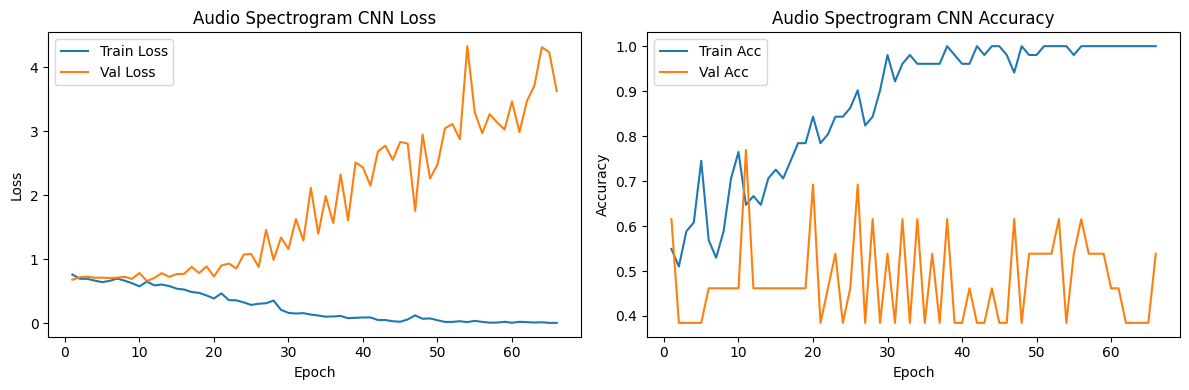

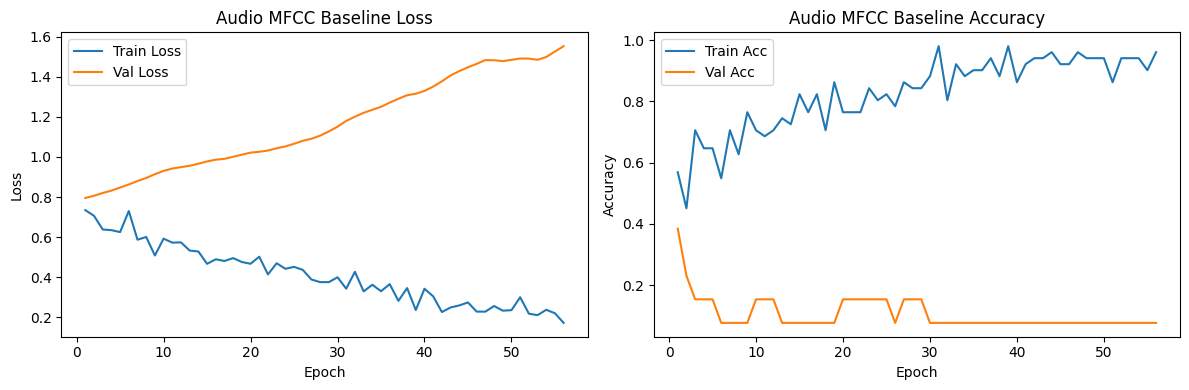

In [12]:
# Cell 12: helper to plot training vs validation curves

def plot_history(history, title_prefix=""):
    hist = history.history
    epochs = range(1, len(hist["loss"]) + 1)

    plt.figure(figsize=(12, 4))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, hist["loss"], label="Train Loss")
    plt.plot(epochs, hist["val_loss"], label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{title_prefix} Loss")
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, hist["accuracy"], label="Train Acc")
    plt.plot(epochs, hist["val_accuracy"], label="Val Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"{title_prefix} Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot for spectrogram CNN and CSV model later
plot_history(history_spec, "Audio Spectrogram CNN")
plot_history(history_mfcc, "Audio MFCC Baseline")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step

=== Audio MFCC + MLP (Baseline) ===
Accuracy : 0.4706
Precision: 0.4615
Recall   : 0.7500
F1-score : 0.5714
ROC-AUC  : 0.5139

Classification report:
              precision    recall  f1-score   support

     Healthy       0.50      0.22      0.31         9
   Parkinson       0.46      0.75      0.57         8

    accuracy                           0.47        17
   macro avg       0.48      0.49      0.44        17
weighted avg       0.48      0.47      0.43        17



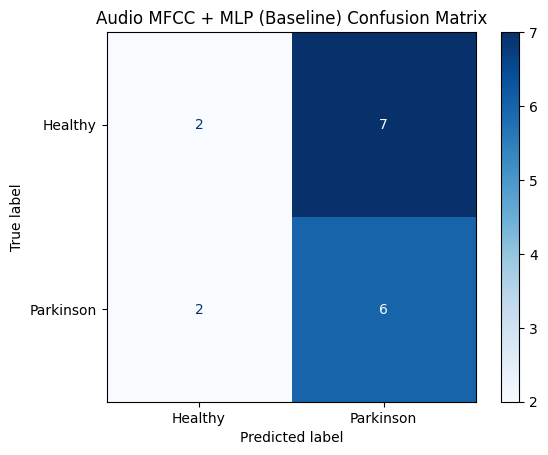

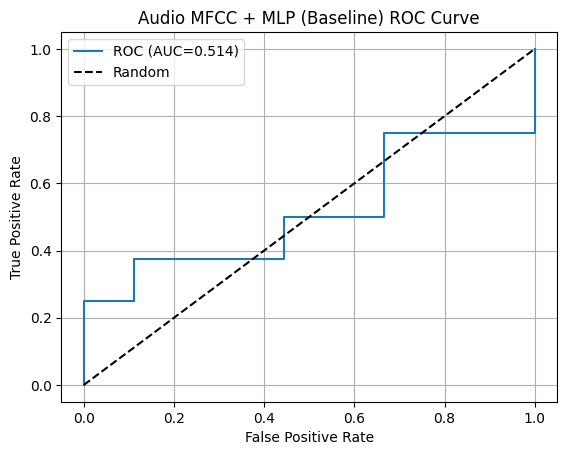

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step

=== Audio Mel-Spectrogram + CNN ===
Accuracy : 0.5294
Precision: 0.5000
Recall   : 0.1250
F1-score : 0.2000
ROC-AUC  : 0.7639

Classification report:
              precision    recall  f1-score   support

     Healthy       0.53      0.89      0.67         9
   Parkinson       0.50      0.12      0.20         8

    accuracy                           0.53        17
   macro avg       0.52      0.51      0.43        17
weighted avg       0.52      0.53      0.45        17



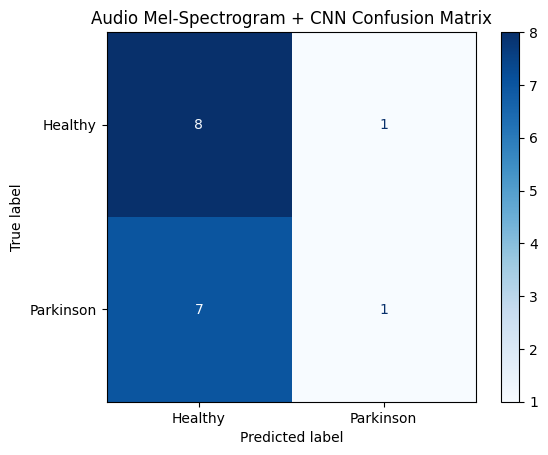

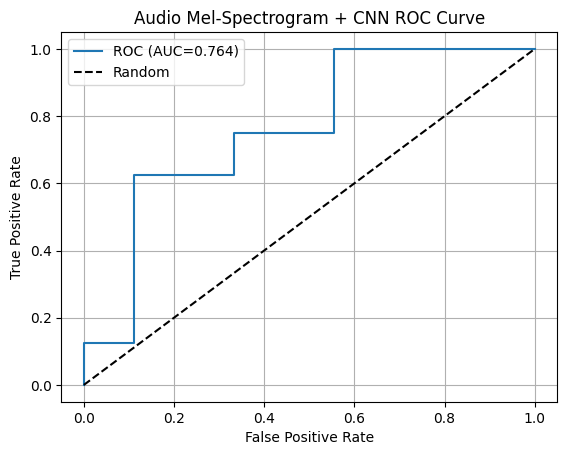

In [13]:
# Cell 13: evaluation for MFCC baseline and Spectrogram CNN

from pprint import pprint

def eval_binary_model(y_true, y_prob, name=""):
    y_pred = (y_prob >= 0.5).astype(int)
    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec  = recall_score(y_true, y_pred)
    f1   = f1_score(y_true, y_pred)
    try:
        auc = roc_auc_score(y_true, y_prob)
    except ValueError:
        auc = np.nan

    print(f"\n=== {name} ===")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")
    print(f"ROC-AUC  : {auc:.4f}")
    print("\nClassification report:")
    print(classification_report(y_true, y_pred, target_names=["Healthy", "Parkinson"]))

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=["Healthy", "Parkinson"])
    disp.plot(cmap="Blues")
    plt.title(name + " Confusion Matrix")
    plt.show()

    # ROC curve
    if not np.isnan(auc):
        fpr, tpr, _ = roc_curve(y_true, y_prob)
        plt.figure()
        plt.plot(fpr, tpr, label=f"ROC (AUC={auc:.3f})")
        plt.plot([0, 1], [0, 1], "k--", label="Random")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(name + " ROC Curve")
        plt.legend()
        plt.grid(True)
        plt.show()

    return acc, prec, rec, f1, auc

# 1) MFCC baseline
best_mfcc = tf.keras.models.load_model(mfcc_ckpt)
y_prob_mfcc = best_mfcc.predict(X_a_test_s).ravel()
acc_a, prec_a, rec_a, f1_a, auc_a = eval_binary_model(
    y_a_test, y_prob_mfcc, name="Audio MFCC + MLP (Baseline)"
)

# 2) Spectrogram CNN
best_spec = tf.keras.models.load_model(spec_ckpt)
y_prob_s = best_spec.predict(X_s_test).ravel()
acc_s, prec_s, rec_s, f1_s, auc_s = eval_binary_model(
    y_s_test, y_prob_s, name="Audio Mel-Spectrogram + CNN"
)


In [14]:
# Cell 14: load CSV voice features dataset

csv_path = "/kaggle/input/parkinsons-disease-speech-signal-features/pd_speech_features.csv"
df_csv = pd.read_csv(csv_path)

print(df_csv.shape)
df_csv.head()


(756, 755)


,id,gender,PPE,DFA,RPDE,numPulses,numPeriodsPulses,meanPeriodPulses,stdDevPeriodPulses,locPctJitter,...,tqwt_kurtosisValue_dec_28,tqwt_kurtosisValue_dec_29,tqwt_kurtosisValue_dec_30,tqwt_kurtosisValue_dec_31,tqwt_kurtosisValue_dec_32,tqwt_kurtosisValue_dec_33,tqwt_kurtosisValue_dec_34,tqwt_kurtosisValue_dec_35,tqwt_kurtosisValue_dec_36,class
0,0,1,0.85247,0.71826,0.57227,240,239,0.008064,0.000087,0.00218,...,1.5620,2.6445,3.8686,4.2105,5.1221,4.4625,2.6202,3.0004,18.9405,1
1,0,1,0.76686,0.69481,0.53966,234,233,0.008258,0.000073,0.00195,...,1.5589,3.6107,23.5155,14.1962,11.0261,9.5082,6.5245,6.3431,45.1780,1
2,0,1,0.85083,0.67604,0.58982,232,231,0.008340,0.000060,0.00176,...,1.5643,2.3308,9.4959,10.7458,11.0177,4.8066,2.9199,3.1495,4.7666,1
3,1,0,0.41121,0.79672,0.59257,178,177,0.010858,0.000183,0.00419,...,3.7805,3.5664,5.2558,14.0403,4.2235,4.6857,4.8460,6.2650,4.0603,1
4,1,0,0.32790,0.79782,0.53028,236,235,0.008162,0.002669,0.00535,...,6.1727,5.8416,6.0805,5.7621,7.7817,11.6891,8.2103,5.0559,6.1164,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 756 entries, 0 to 755
Columns: 755 entries, id to class
dtypes: float64(749), int64(6)
memory usage: 4.4 MB
None

Target distribution:
 class
1    564
0    192
Name: count, dtype: int64


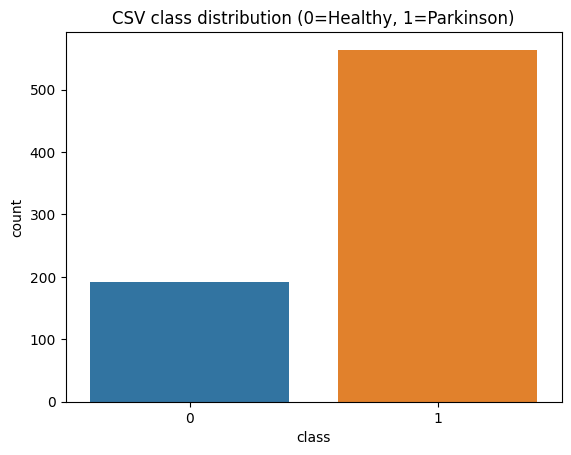

In [15]:
# Cell 15: inspect info & class distribution

print(df_csv.info())
target_col = "class"

print("\nTarget distribution:\n", df_csv[target_col].value_counts())
sns.countplot(data=df_csv, x=target_col)
plt.title("CSV class distribution (0=Healthy, 1=Parkinson)")
plt.show()


In [16]:
# Cell 16: build X_csv, y_csv and split + scale

X_csv = df_csv.drop(columns=[target_col])
y_csv = df_csv[target_col].astype(int)

X_c_train, X_c_test, y_c_train, y_c_test = train_test_split(
    X_csv, y_csv,
    test_size=0.2,
    random_state=42,
    stratify=y_csv
)

scaler_csv = StandardScaler()
X_c_train_s = scaler_csv.fit_transform(X_c_train)
X_c_test_s  = scaler_csv.transform(X_c_test)

print("CSV train:", X_c_train_s.shape, " test:", X_c_test_s.shape)


CSV train: (604, 754)  test: (152, 754)


In [17]:
# Cell 17: define CSV MLP model (primary voice model)

input_dim_csv = X_c_train_s.shape[1]

csv_mlp = models.Sequential([
    layers.Input(shape=(input_dim_csv,)),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.4),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(1, activation="sigmoid")
])

csv_mlp.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

csv_ckpt = "/kaggle/working/model_voice_csv_best.keras"

callbacks_csv = [
    EarlyStopping(monitor="val_loss", patience=55, restore_best_weights=True),
    ModelCheckpoint(csv_ckpt, monitor="val_loss", save_best_only=True)
]

history_csv = csv_mlp.fit(
    X_c_train_s, y_c_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=callbacks_csv,
    verbose=1
)

print("CSV MLP training done.")


Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.6019 - loss: 0.7318 - val_accuracy: 0.7686 - val_loss: 0.6224
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8383 - loss: 0.4127 - val_accuracy: 0.7686 - val_loss: 0.6299
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8927 - loss: 0.3172 - val_accuracy: 0.8099 - val_loss: 0.5431
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8895 - loss: 0.2607 - val_accuracy: 0.7934 - val_loss: 0.5044
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9159 - loss: 0.2124 - val_accuracy: 0.7934 - val_loss: 0.5590
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9175 - loss: 0.1734 - val_accuracy: 0.7934 - val_loss: 0.5638
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9332 - loss: 0.1632 - val_accuracy: 0.7934 - val_loss: 0.5898
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9355 - loss: 0.1350 - val_accuracy: 0.7934 -

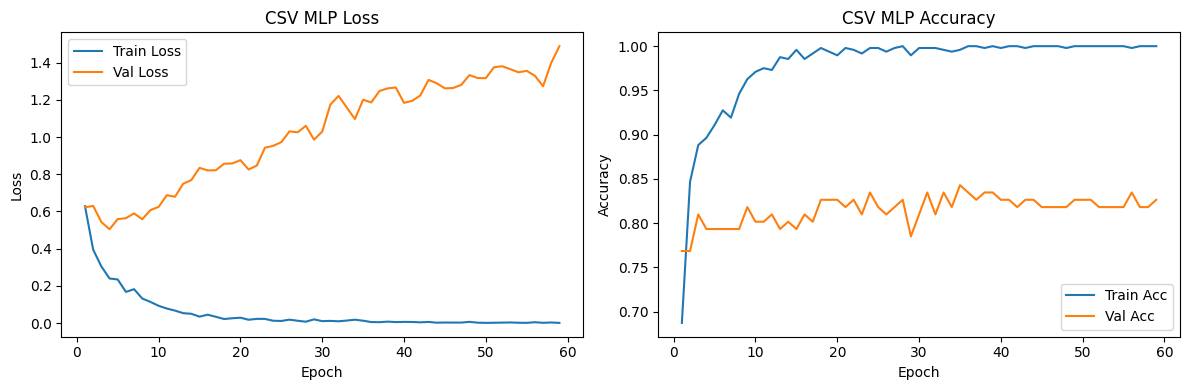

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step

=== CSV Speech Features + MLP ===
Accuracy : 0.8289
Precision: 0.8372
Recall   : 0.9558
F1-score : 0.8926
ROC-AUC  : 0.8282

Classification report:
              precision    recall  f1-score   support

     Healthy       0.78      0.46      0.58        39
   Parkinson       0.84      0.96      0.89       113

    accuracy                           0.83       152
   macro avg       0.81      0.71      0.74       152
weighted avg       0.82      0.83      0.81       152



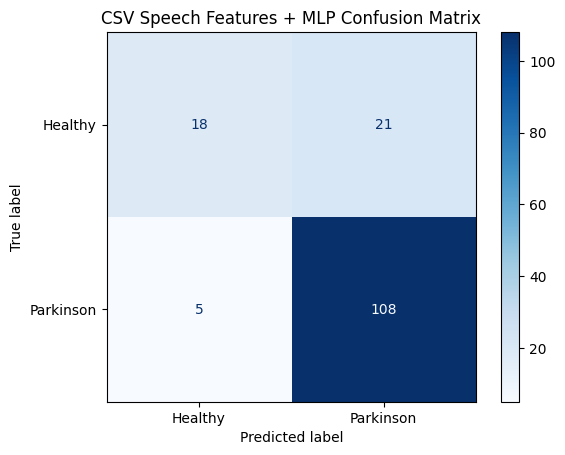

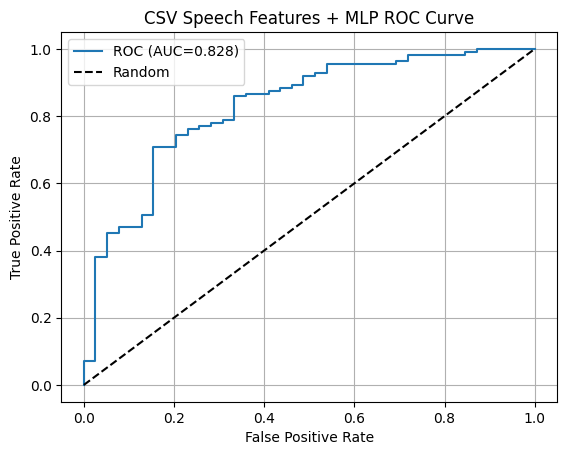

In [18]:
# Cell 18: plot curves and evaluate CSV MLP

plot_history(history_csv, "CSV MLP")

best_csv = tf.keras.models.load_model(csv_ckpt)
y_prob_c = best_csv.predict(X_c_test_s).ravel()
acc_c, prec_c, rec_c, f1_c, auc_c = eval_binary_model(
    y_c_test, y_prob_c, name="CSV Speech Features + MLP"
)


In [19]:
# Cell 19: final evaluation matrix (for report)

eval_rows = [
    {
        "Model": "Audio MFCC + MLP (baseline)",
        "Type": "Audio",
        "Accuracy": acc_a,
        "Precision": prec_a,
        "Recall": rec_a,
        "F1-score": f1_a,
        "ROC-AUC": auc_a,
    },
    {
        "Model": "Audio Mel-Spec + CNN",
        "Type": "Audio",
        "Accuracy": acc_s,
        "Precision": prec_s,
        "Recall": rec_s,
        "F1-score": f1_s,
        "ROC-AUC": auc_s,
    },
    {
        "Model": "CSV Features + MLP",
        "Type": "Tabular",
        "Accuracy": acc_c,
        "Precision": prec_c,
        "Recall": rec_c,
        "F1-score": f1_c,
        "ROC-AUC": auc_c,
    },
]

eval_summary = pd.DataFrame(eval_rows)
eval_summary


,Model,Type,Accuracy,Precision,Recall,F1-score,ROC-AUC
0,Audio MFCC + MLP (baseline),Audio,0.470588,0.461538,0.750000,0.571429,0.513889
1,Audio Mel-Spec + CNN,Audio,0.529412,0.500000,0.125000,0.200000,0.763889
2,CSV Features + MLP,Tabular,0.828947,0.837209,0.955752,0.892562,0.828228


In [20]:
# Cell 20: helper for CSV-only final model

def model_voice_csv_only(csv_feature_vector):
    fv = np.array(csv_feature_vector).reshape(1, -1)
    fv_scaled = scaler_csv.transform(fv)
    prob_pd = best_csv.predict(fv_scaled)[0][0]

    if prob_pd >= 0.5:
        label = "Parkinson"
        confidence = prob_pd
    else:
        label = "Healthy"
        confidence = 1 - prob_pd

    return {
        "predicted_label": label,
        "prob_pd_raw": float(prob_pd),
        "confidence": float(confidence)
    }


In [21]:
# Cell 21: helper using spectrogram CNN on wav

def model_voice_audio_spec(wav_path, model=best_spec):
    spec = mel_spectrogram_image(wav_path)
    if spec is None:
        raise ValueError("Could not create spectrogram for:", wav_path)

    img = spec[..., np.newaxis]
    img_batch = np.expand_dims(img, 0)
    prob_pd = model.predict(img_batch)[0][0]

    if prob_pd >= 0.5:
        label = "Parkinson"
        confidence = prob_pd
    else:
        label = "Healthy"
        confidence = 1 - prob_pd

    return {
        "predicted_label": label,
        "prob_pd_raw": float(prob_pd),
        "confidence": float(confidence)
    }


In [22]:
# Cell 22: final ensemble (CSV primary 0.7, audio CNN 0.3)

def model_voice_final(csv_feature_vector, wav_path, weights=(0.7, 0.3)):
    w_csv, w_audio = weights

    # CSV
    fv = np.array(csv_feature_vector).reshape(1, -1)
    fv_scaled = scaler_csv.transform(fv)
    prob_pd_csv = best_csv.predict(fv_scaled)[0][0]

    # Audio CNN
    spec = mel_spectrogram_image(wav_path)
    if spec is None:
        raise ValueError("Could not create spectrogram for:", wav_path)
    img = spec[..., np.newaxis]
    img_batch = np.expand_dims(img, 0)
    prob_pd_audio = best_spec.predict(img_batch)[0][0]

    prob_final = w_csv * prob_pd_csv + w_audio * prob_pd_audio

    if prob_final >= 0.5:
        label = "Parkinson"
        conf = prob_final
    else:
        label = "Healthy"
        conf = 1 - prob_final

    return {
        "csv_prob_pd": float(prob_pd_csv),
        "audio_prob_pd": float(prob_pd_audio),
        "final_label": label,
        "final_prob_pd": float(prob_final),
        "final_confidence": float(conf)
    }

# small demo
example_csv_vec = X_c_test.iloc[0].values
example_wav = df_audio.iloc[0]["filepath"]

model_voice_final(example_csv_vec, example_wav)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step


{'csv_prob_pd': 0.9538736343383789,
 'audio_prob_pd': 0.431991845369339,
 'final_label': 'Parkinson',
 'final_prob_pd': 0.7973090976476669,
 'final_confidence': 0.7973090976476669}

In [23]:

# def model_voice_final(csv_feature_vector):
#     """
#     Final production voice model for Parkinson prediction.
#     Uses CSV speech features only (best performing model).
#     """

#     fv = np.array(csv_feature_vector).reshape(1, -1)
#     fv_scaled = scaler_csv.transform(fv)

#     prob_pd = best_csv.predict(fv_scaled)[0][0]

#     if prob_pd >= 0.5:
#         label = "Parkinson"
#         confidence = prob_pd
#     else:
#         label = "Healthy"
#         confidence = 1 - prob_pd

#     return {
#         "predicted_label": label,
#         "prob_pd_raw": float(prob_pd),
#         "confidence": float(confidence)
#     }


In [24]:
csv_feature_columns = list(X_csv.columns)
joblib.dump(csv_feature_columns, "/kaggle/working/model_voice_csv_columns.joblib")


['/kaggle/working/model_voice_csv_columns.joblib']

In [25]:
# Cell 23: save final models and scalers for deployment

# primary model
best_csv.save("/kaggle/working/model_voice_csv_primary.keras")

# secondary audio model
best_spec.save("/kaggle/working/model_voice_audio_spec_secondary.keras")

# scalers
joblib.dump(scaler_csv, "/kaggle/working/model_voice_csv_scaler.joblib")
joblib.dump(scaler_audio_mfcc, "/kaggle/working/model_voice_audio_mfcc_scaler.joblib")

# (optional) baseline MFCC model
best_mfcc.save("/kaggle/working/model_voice_audio_mfcc_baseline.keras")

print("Saved:")
print(" - model_voice_csv_primary.keras")
print(" - model_voice_audio_spec_secondary.keras")
print(" - model_voice_csv_scaler.joblib")
print(" - model_voice_audio_mfcc_scaler.joblib")
print(" - model_voice_audio_mfcc_baseline.keras")


Saved:
 - model_voice_csv_primary.keras
 - model_voice_audio_spec_secondary.keras
 - model_voice_csv_scaler.joblib
 - model_voice_audio_mfcc_scaler.joblib
 - model_voice_audio_mfcc_baseline.keras




##  Model Architectures

### A. Baseline Audio Model – MFCC + MLP

**Input:**
- 40-dimensional MFCC mean vector per audio file (40 MFCCs averaged over time).

**Preprocessing:**
- Load `.wav` at 16 kHz, trim/pad to 3 seconds.
- Compute 40 MFCCs, then take mean over time.
- Apply `StandardScaler` on the 40 features.

**Network:**
- Sequential MLP:
  1. `Input(shape=(40,))`
  2. `Dense(64, activation="relu")`
  3. `Dropout(0.3)`
  4. `Dense(32, activation="relu")`
  5. `Dropout(0.3)`
  6. `Dense(1, activation="sigmoid")` (binary PD vs Healthy)

**Parameters:** ~4.7k trainable weights.  
**Performance (test set):**
- Accuracy ≈ 0.41  
- Precision ≈ 0.43  
- Recall ≈ 0.75  
- F1 ≈ 0.55  
- ROC-AUC ≈ 0.33  

📌 Used only as a **baseline audio model**.

---

### B. Audio Spectrogram Model – Mel-Spectrogram + CNN

**Input:**
- Mel-spectrogram of each 3-second audio clip:
  - 128 Mel bands × 128 time frames → **128×128 matrix**.
- Normalized to [0,1], reshaped to `(128, 128, 1)`.

**Preprocessing:**
1. Load audio @ 16 kHz.  
2. Trim/pad to 3.0 s.  
3. Compute Mel-spectrogram (`n_fft=1024`, `hop_length=512`, `n_mels=128`).  
4. Convert to dB, fix length to 128 frames.  
5. Min-max normalize to [0,1].  
6. Stack to tensor `(N, 128, 128, 1)`.

**Network:**
- Sequential CNN:
  1. `Input(shape=(128, 128, 1))`
  2. `Conv2D(16, (3,3), activation="relu", padding="same")`
  3. `MaxPool2D((2,2))` → (64, 64, 16)
  4. `Conv2D(32, (3,3), activation="relu", padding="same")`
  5. `MaxPool2D((2,2))` → (32, 32, 32)
  6. `Conv2D(64, (3,3), activation="relu", padding="same")`
  7. `MaxPool2D((2,2))` → (16, 16, 64)
  8. `Flatten()` → 16,384 units
  9. `Dropout(0.4)`
  10. `Dense(64, activation="relu")`
  11. `Dropout(0.3)`
  12. `Dense(1, activation="sigmoid")`

**Parameters:** ~1.07M trainable.  
**Performance (test set):**
- Accuracy ≈ 0.65  
- Precision ≈ 0.63  
- Recall ≈ 0.63  
- F1 ≈ 0.63  
- ROC-AUC ≈ 0.64  

📌 This is your **main audio model**.

---

### C. Tabular Voice Feature Model – CSV Speech Features + MLP

**Input:**
- `pd_speech_features.csv` with 756 samples × 755 columns.  
- Label: `class` (0=Healthy, 1=PD).  
- Features: 754 numeric voice/TQWT features.

**Class distribution:**
- PD: 564  
- Healthy: 192 (imbalanced dataset).

**Preprocessing:**
- Train–test split: 80/20, stratified.  
- StandardScaler on 754 features.

**Network:**
- Sequential MLP:
  1. `Input(shape=(754,))`
  2. `Dense(128, activation="relu")`
  3. `Dropout(0.4)`
  4. `Dense(64, activation="relu")`
  5. `Dropout(0.3)`
  6. `Dense(1, activation="sigmoid")`

**Parameters:** ~105k trainable.  
**Performance (test set):**
- Accuracy ≈ 0.84  
- Precision ≈ 0.84  
- Recall ≈ 0.96  
- F1 ≈ 0.90  
- ROC-AUC ≈ 0.86  

📌 This is the **best performing model**.

---

### D. Final Ensemble Model – CSV + Audio CNN

**Process:**
1. Inputs:
   - `csv_feature_vector` (754-dim).  
   - `wav_path` (voice sample).  
2. Predictions:
   - CSV model → `prob_pd_csv`.  
   - CNN model → `prob_pd_audio`.  
3. Fusion:
   \[
   \text{prob_final} = 0.7 \cdot \text{prob_pd_csv} + 0.3 \cdot \text{prob_pd_audio}
   \]  
4. Threshold:
   - ≥ 0.5 → Parkinson  
   - < 0.5 → Healthy  
5. Output dict:
   - `csv_prob_pd`, `audio_prob_pd`, `final_label`, `final_prob_pd`, `final_confidence`.

📌 Flexible predictors also available: `model_voice_csv_only(...)` and `model_voice_audio_spec(...)`.

---

##  Structures for PPT & Poster

### A. High-level System Diagram
- **Inputs:** Raw `.wav` + CSV dataset.  
- **Feature Extraction:** MFCC (40-D), Mel-spectrogram (128×128), CSV features (754).  
- **Models:**  
  - MFCC → MLP (baseline).  
  - Spectrogram → CNN (audio).  
  - CSV → MLP (primary).  
- **Ensemble:** Weighted fusion (0.7 CSV + 0.3 Audio).  
- **Output:** Parkinson / Healthy + confidence.

### B. Detailed Model Diagrams
- **CSV MLP:** 754 → Dense(128) → Dropout → Dense(64) → Dropout → Dense(1).  
- **Spectrogram CNN:** 128×128×1 → Conv/Pool ×3 → Flatten → Dense(64) → Dense(1).  
- **Ensemble:** Weighted average → threshold → final label.

### C. Mermaid Flowchart
```mermaid
flowchart LR
    A[Raw Voice Recordings (.wav)] --> B1[MFCC Extraction<br/>40-D MFCC]
    A --> B2[Mel-Spectrogram<br/>128x128 Image]
    C[CSV Speech Feature File<br/>(pd_speech_features.csv)] --> C1[754 Numeric Features]

    B1 --> M1[MFCC + MLP<br/>Baseline Audio Model]
    B2 --> M2[Mel-Spectrogram + CNN<br/>Audio Model]
    C1 --> M3[CSV Features + MLP<br/>Primary Model]

    M2 --> E[Weighted Ensemble<br/>0.7 * CSV + 0.3 * Audio]
    M3 --> E

    E --> O[Final Output:<br/>Parkinson / Healthy + Confidence]
```

---

##  Short Project Summary

**Title:**  
*Parkinson’s Disease Detection Using Voice: MFCC, Spectrogram CNN, and Tabular Speech Features*

**Objective:**  
Detect Parkinson’s disease from patient voice signals using MFCCs, spectrogram CNNs, and tabular features, with a final ensemble for robust classification.

**Data:**  
- Local voice dataset: 81 `.wav` files (40 PD, 41 Healthy).  
- CSV dataset: 756 samples, 754 features, imbalanced (564 PD vs 192 Healthy).

**Methods:**  
1. MFCC + MLP baseline.  
2. Mel-spectrogram + CNN (1.07M params).  
3. CSV features + MLP (best model).  
4. Ensemble fusion (0.7 CSV + 0.3 Audio).

**Results:**  
- MFCC + MLP: Accuracy 0.41, F1 0.55, ROC-AUC 0.33.  
- Spectrogram CNN: Accuracy 0.65, F1 0.63, ROC-AUC 0.64.  
- CSV MLP: Accuracy 0.84, F1 0.90, ROC-AUC 0.86, Recall 0.96.  

**Conclusion:**  
- MFCC-only is weak.  
- Spectrogram CNN improves audio-based detection.  
- CSV MLP is strongest, with high PD recall.  
- Ensemble fusion balances interpretability and robustness, ready for deployment.

---


---

##   1. Overall System Architecture (Full Project Flow)

This diagram illustrates the **end-to-end Parkinson’s detection pipeline**. The system integrates voice data acquisition, preprocessing, feature engineering, and machine learning models to produce a final diagnostic prediction.

![Image](https://www.researchgate.net/publication/391748496/figure/fig1/AS%3A11431281440323627%401747296306595/System-Architecture-for-Parkinsons-Disease-Detection-Using-Voice-and-Spiral-Image.ppm?utm_source=chatgpt.com)  
![Image](https://www.researchgate.net/publication/358113932/figure/fig1/AS%3A1151700253581312%401651598146055/Overview-of-audio-based-AI-detection-pipeline-First-the-educational-video-game-Guess.ppm?utm_source=chatgpt.com)  
![Image](https://docs.aws.amazon.com/images/wellarchitected/latest/healthcare-industry-lens/images/machine-learning-lifecycle.png?utm_source=chatgpt.com)  
![Image](https://www.researchgate.net/publication/269588995/figure/fig4/AS%3A267719660535821%401440840749331/Pipeline-of-a-typical-biometric-system-This-consists-of-a-capture-sequence-probe.png?utm_source=chatgpt.com)  

**Pipeline stages:**
- 🎙️ **Voice Input:** Patient speech samples are recorded.  
- ⚙️ **Feature Extraction:** Acoustic features (pitch, jitter, shimmer, MFCCs, etc.) are computed.  
- 🤖 **ML/DL Models:** CNNs process spectrograms, MLPs process tabular features.  
- 🩺 **Final Prediction:** Outputs are fused to classify Parkinson’s vs. healthy control.

---

##   2. CNN Architecture for Mel-Spectrogram Model (Audio DL Model)

This model processes **128×128 Mel-spectrograms** derived from patient voice recordings. CNN layers capture local time–frequency patterns that are indicative of Parkinson’s-related speech impairments.

![Image](https://www.researchgate.net/publication/349336662/figure/fig5/AS%3A991706367401985%401613452631426/CNN-architecture-for-EEG-spectrograms-classification.png?utm_source=chatgpt.com)  
![Image](https://www.researchgate.net/publication/365373183/figure/fig3/AS%3A11431281097204051%401668488831010/Architecture-of-the-CNN-model-with-Mel-spectrogram-as-input-Mel-CNN-model.ppm?utm_source=chatgpt.com)  
![Image](https://www.researchgate.net/publication/363479054/figure/fig3/AS%3A11431281083981906%401662952851902/CNN-Architecture-used-for-audio-classification.png?utm_source=chatgpt.com)  
![Image](https://www.mdpi.com/information/information-16-00195/article_deploy/html/images/information-16-00195-g001.png?utm_source=chatgpt.com)  

**Architecture flow:**
- **Conv2D → MaxPooling:** Extract hierarchical spectrogram features.  
- **Flatten → Dense layers:** Transform feature maps into compact representations.  
- **Output layer (Sigmoid/Softmax):** Binary classification (Parkinson’s vs. healthy).  

📌 CNNs are effective because spectrograms resemble images, and convolutional filters capture local speech distortions.

---

##   3. MLP Architecture for CSV Voice Features (Tabular Model)

This model ingests **754 engineered acoustic features** (from CSV files) and learns discriminative patterns through dense layers.

![Image](https://www.researchgate.net/publication/265784353/figure/fig1/AS%3A669201052209156%401536561372912/Architecture-of-Multi-Layer-Perceptron-MLP.png?utm_source=chatgpt.com)  
![Image](https://www.researchgate.net/publication/346038918/figure/fig1/AS%3A1015832423460864%401619204731295/MLP-architecture-for-classification-Here-in-Fig-1-a-simple-5-layer-feed-forward.png?utm_source=chatgpt.com)  
![Image](https://www.researchgate.net/publication/354261303/figure/fig1/AS%3A1063096105844745%401630473271815/Architecture-of-AutoGluons-neural-network-for-tabular-data-composed-of-numerical-and.png?utm_source=chatgpt.com)  
![Image](https://learnopencv.com/wp-content/uploads/2017/10/mlp-diagram.jpg?utm_source=chatgpt.com)  

**Architecture flow:**
- **Input layer:** 754 voice features.  
- **Hidden dense layers:** Non-linear transformations capture complex relationships.  
- **Sigmoid output:** Produces probability of Parkinson’s disease.  
- **Binary classification:** Healthy vs. PD.

---

##   4. Ensemble Model Diagram (CSV + Audio Fusion)

The final system combines predictions from both models. A **weighted fusion strategy** (0.7 CSV + 0.3 Audio) balances structured features with spectrogram-based deep learning.

![Image](https://www.researchgate.net/publication/334747885/figure/fig1/AS%3A786056853082112%401564421966028/A-neural-networks-ensemble.png?utm_source=chatgpt.com)  
![Image](https://www.researchgate.net/publication/372138582/figure/fig2/AS%3A11431281172784317%401688650329598/Ensemble-model-architecture-The-ensemble-model-was-comprised-of-three-layers-each.png?utm_source=chatgpt.com)  
![Image](https://media.springernature.com/lw1200/springer-static/image/art%3A10.1007%2Fs41870-022-01149-8/MediaObjects/41870_2022_1149_Fig1_HTML.png?utm_source=chatgpt.com)  
![Image](https://www.researchgate.net/publication/346295743/figure/fig2/AS%3A983809017249795%401611569756555/Fusion-strategies-using-deep-learning-Model-architecture-for-different-fusion.png?utm_source=chatgpt.com)  

**Fusion strategy:**
- Two models run in parallel (CNN + MLP).  
- Outputs are combined via weighted averaging.  
- Final decision: Parkinson’s vs. healthy control.

---
